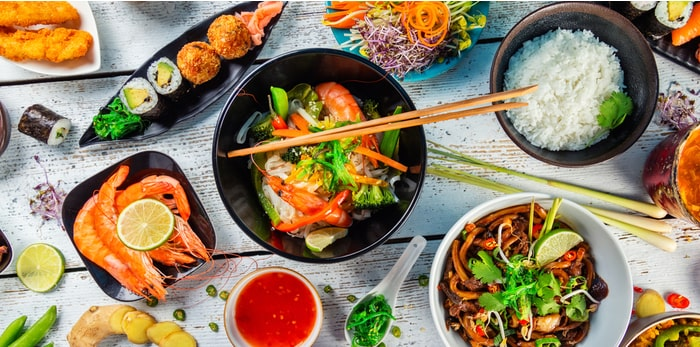

# Where to start a new Asian restaurant?
#### Can we make an ideal decision on the location of a brand-new restaurant by analyzing data of neighborhoods and other restaurants?
#### For that reason, this capstone is aiming at finding promising sites for an Asian restaurant. In this capstone, an ideal site will be in a neighborhood with a large census, high average income, a high proportion of Asian and accessible parking and transportation. Lastly, the distribution of similar restaurants should be low. These advantages increase the likelihood of attracting affordable consumers to an Asian restaurant. The list of ideal sites can be valuable to any individual or company who want to start running an Asian Restaurant.

In [16]:
import pandas as pd
import numpy as np
import string
import requests
import geocoder
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
import csv

### 1. Dara Preperation

#### (1).The geographical scope is Toronto, so I continue to use the geographical neighbourhoods data I got last week  [applied_data_science_capstone.ipynb](https://github.com/JiaqiChen0119/coursera-IBM-capstone/blob/master/applied_data_science_capstone.ipynb)

In [14]:
toronto_data = pd.read_csv('toronto_data.csv')

In [15]:
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [58]:
toronto_data['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

#### (2). the neighborhood profile  
* population of working age
* the number of people whose mother tongue is Japanese, Chinese Languages, and Korean

In [4]:
pd.read_csv('neighbourhood-profiles-2016-readme.csv')

,_id,Field Name / Item / Column name,Description / Definition
0,1,See attached .csv data document,Definitions of most fields are as defined by t...
1,2,NaN,http://www12.statcan.gc.ca/census-recensement/...
2,3,Neighbourhood,"In this file, the word neighbourhood is used t..."
3,4,TSNS Designation,This concept refers to the designation assigne...
4,5,TSNS Designation: NIA,This neighbourhood was designated as a Neighbo...
5,6,TSNS Designation: Emerging Neighbourhood,This neighbourhood was not designated as an NI...
6,7,TSNS Designation: No designation,This neighbourhood was not designated as an NI...


In [115]:
pro = pd.read_csv('neighbourhood-profiles-2016-csv.csv')

In [117]:
pro.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [118]:
pro = pro.set_index('Category')

In [121]:
pro.index.unique()
    

Index(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Visible minority', 'Ethnic origin',
       'Aboriginal peoples', 'Education', 'Housing', 'Language of work',
       'Labour', 'Journey to work', 'Mobility'],
      dtype='object', name='Category')

In [122]:
pro = pro.loc[['Population','Income','Ethnic origin']]

In [123]:
pro.head()

,_id,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
Category,,,,,,,,,,,,,,,,,,,,,
Population,3,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
Population,4,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
Population,5,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%
Population,6,Population and dwellings,Census Profile 98-316-X2016001,Total private dwellings,"1,179,057","9,371","8,535","4,732","18,109","12,473",...,"8,054","8,721","19,098","5,620","3,604","6,185","6,103","7,475","11,051","5,847"
Population,7,Population and dwellings,Census Profile 98-316-X2016001,Private dwellings occupied by usual residents,"1,112,929","9,120","8,136","4,616","15,934","12,124",...,"7,549","8,509","18,436","5,454","3,449","5,887","5,676","7,012","10,170","5,344"


In [125]:
pro.reset_index(inplace=True)

In [126]:
pro = pro.drop(columns=['_id','Category','Topic','Data Source'],axis=0).set_index('Characteristic')

In [127]:
pro

,index,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
Characteristic,,,,,,,,,,,,,,,,,,,,,
"Population, 2016",0,"2,731,571","29,113","23,757","12,054","30,526","27,695","15,873","25,797","21,396",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
"Population, 2011",1,"2,615,060","30,279","21,988","11,904","29,177","26,918","15,434","19,348","17,671",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
Population Change 2011-2016,2,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,2.80%,33.30%,21.10%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%
Total private dwellings,3,"1,179,057","9,371","8,535","4,732","18,109","12,473","6,418","18,436","10,111",...,"8,054","8,721","19,098","5,620","3,604","6,185","6,103","7,475","11,051","5,847"
Private dwellings occupied by usual residents,4,"1,112,929","9,120","8,136","4,616","15,934","12,124","6,089","15,074","9,532",...,"7,549","8,509","18,436","5,454","3,449","5,887","5,676","7,012","10,170","5,344"
Population density per square kilometre,5,"4,334","3,929","3,034","2,435","10,863","2,775","3,377","14,097","4,195",...,"5,820","4,007","4,345","7,838","6,722","8,541","7,162","10,708","2,086","2,451"
Land area in square kilometres,6,630.2,7.41,7.83,4.95,2.81,9.98,4.7,1.83,5.1,...,2.91,5.53,12.31,1.6,1.17,1.68,1.65,1.17,13.23,6.04
Children (0-14 years),7,"398,135","3,840","3,075","1,760","2,360","3,605","2,325","1,695","2,415",...,"1,785","3,555","9,625","2,325","1,165","1,860","1,800","1,210","4,045","1,960"
Youth (15-24 years),8,"340,270","3,705","3,360","1,235","3,750","2,730","1,940","6,860","2,505",...,"2,230","2,625","7,660","1,035",675,"1,320","1,225",920,"4,750","1,870"


In [128]:
pro2 = pd.DataFrame(pro.values.T, index=pro.columns, columns=pro.index)

In [179]:
nbh_char = pro2[['Working Age (25-54 years)','    Employment income: Average amount ($)',' Chinese',' Japanese',' Korean']].drop(axis = 0,index = 'index')

In [180]:
del nbh_char.columns.name

In [181]:
nbh_char.rename(columns={'Working Age (25-54 years)':'Working Population',
                         '    Employment income: Average amount ($)':'Average Employment Income',
                        ' Chinese':'Chinese',' Japanese':'Japanses',' Korean':'Korean'},inplace = True)

In [184]:
nbh_char.reset_index(inplace = True)

In [185]:
nbh_char.rename(columns = {'index':'Neighbourhood'},inplace = True)

In [227]:
nbh_char.shape

(141, 6)

In [186]:
nbh_char.head()

,Neighbourhood,Working Population,Average Employment Income,Chinese,Japanses,Korean
0,City of Toronto,"1,229,555","54,032","332,830","17,265","43,455"
1,Agincourt North,"11,305","31,860","16,950",60,100
2,Agincourt South-Malvern West,"9,965","33,908","11,455",60,145
3,Alderwood,"5,220","49,899",420,50,75
4,Annex,"15,040","102,593","2,400",285,635


In [187]:
pccan = pd.read_csv('pccan.csv')

In [215]:
neis = set()
for nei in nbh_char['Neighbourhood']:
    if nei in list(pccan['Neighbourhood'].values):
        print(nei)
        neis.add(nei)

Agincourt North
Alderwood
Bathurst Manor
Bayview Village
Cliffcrest
Dorset Park
Flemingdon Park
Forest Hill North
Guildwood
Henry Farm
Highland Creek
Hillcrest Village
Humber Summit
Humewood-Cedarvale
Ionview
Kennedy Park
Little Portugal
Long Branch
Malvern
Markland Wood
Milliken
Morningside
Mount Dennis
New Toronto
Oakridge
Regent Park
Roncesvalles
Rouge
Scarborough Village
The Beaches
Thorncliffe Park
Victoria Village
West Hill
Weston
Willowdale West
Woburn


In [314]:
useful_profile = nbh_char[nbh_char['Neighbourhood'].isin(neis)]

In [315]:
useful_profile = pd.merge(pccan[pccan['Neighbourhood'].isin(neis)].set_index('Neighbourhood')[['Postcode']],useful_profile.set_index('Neighbourhood'),left_index=True, right_index=True)

In [316]:
useful_profile.reset_index(inplace=True)

In [317]:
useful_profile.dtypes

Neighbourhood                object
Postcode                     object
Working Population           object
Average Employment Income    object
Chinese                      object
Japanses                     object
Korean                       object
dtype: object

transform string into numerica data

In [303]:
import string
def clean_punc(x):
    return ((''.join([c for c in x if c not in string.punctuation])))

In [310]:
useful_profile.columns

Index(['Neighbourhood', 'Postcode', 'Working Population',
       'Average Employment Income', 'Chinese', 'Japanses', 'Korean'],
      dtype='object')

In [318]:
for x in ['Working Population','Average Employment Income', 'Chinese', 'Japanses', 'Korean']:
    useful_profile[x] = useful_profile[x].apply(lambda x:clean_punc(x)).apply(int)

In [319]:
useful_profile.dtypes

Neighbourhood                object
Postcode                     object
Working Population            int64
Average Employment Income     int64
Chinese                       int64
Japanses                      int64
Korean                        int64
dtype: object

In [322]:
useful_profile_scope = pd.merge(useful_profile[['Postcode', 'Working Population', 'Chinese', 'Japanses', 'Korean']].groupby('Postcode').sum(),useful_profile[['Postcode', 'Average Employment Income']].groupby('Postcode').mean(),left_index=True, right_index=True)

In [326]:
useful_profile_scope['Average Employment Income'] = useful_profile_scope['Average Employment Income'].apply(round)

In [327]:
useful_profile_scope

,Working Population,Chinese,Japanses,Korean,Average Employment Income
Postcode,,,,,
M1B,36375,7120,180,150,36158
M1C,4620,1195,45,115,40718
M1E,20975,2965,255,205,40098
M1G,21945,4385,140,225,32810
M1J,6685,665,55,20,34067
M1K,13170,2095,155,130,33480
M1L,6050,825,50,45,29081
M1M,6070,1040,115,60,45539
M1P,10485,3115,95,15,34113


In [330]:
list(useful_profile_scope.index.values)

array(['M1B', 'M1C', 'M1E', 'M1G', 'M1J', 'M1K', 'M1L', 'M1M', 'M1P',
       'M1V', 'M2H', 'M2J', 'M2K', 'M2R', 'M3C', 'M3H', 'M4A', 'M4E',
       'M4H', 'M5A', 'M5P', 'M6C', 'M6J', 'M6M', 'M6R', 'M8V', 'M8W',
       'M9C', 'M9L', 'M9N'], dtype=object)

In [331]:
toronto_scope = toronto_data[toronto_data['PostalCode'].isin(list(useful_profile_scope.index.values))]

In [332]:
toronto_scope.shape

(30, 5)

In [337]:
toronto_scope = pd.merge(toronto_scope.set_index('PostalCode'),useful_profile_scope,left_index=True, right_index=True)

#### (3). the number and distribution of parking, bus stops and metro stations of each neighborhood  
__search for Parking and public-transportation stations(bus stop and metro station) in each neighborhood.__  
* Parking (Foursquare Category Id: '4c38df4de52ce0d596b336e1')
* Public transportation:
  * Bus station (Foursquare Category Id: '4bf58dd8d48988d1fe931735')  
  * Bus stop (Foursquare Category Id: '52f2ab2ebcbc57f1066b8b4f')  
  * Metro station (Foursquare Category Id: '4bf58dd8d48988d1fd931735')  

In [234]:
CLIENT_ID = 'AAOIDTJMJGHIQSS4CK51C2HZD52KB5U45JLQX0YIYW0BDPF3' # your Foursquare ID
CLIENT_SECRET = 'X5TCGWCVL3FSRJSUMYMOU3PJN0JZAZAAAVD4LKAV33S1VQWC' # your Foursquare Secret
VERSION = '20180605'

In [235]:
ID = ['4c38df4de52ce0d596b336e1','4bf58dd8d48988d1fe931735','52f2ab2ebcbc57f1066b8b4f','4bf58dd8d48988d1fd931735']

In [342]:
def getNearbyTransport(names,latitudes,longitudes,ID,Radius = 500,LIMIT = 100):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url_park = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lng,
                VERSION,
                ID[0],
                Radius,
                LIMIT)
        # make the GET request
        try:
            results_park = requests.get(url_park).json()['response']['venues']
            count_park = np.shape(results_park)[0]
        except:
            count_park = 0
        try:
            url_bus1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lng,
                VERSION,
                ID[1],
                Radius,
                LIMIT)
            # make the GET request
            results_bus1 = requests.get(url_bus1).json()['response']['venues']
            count_bus1 = np.shape(results_bus1)[0]
        except:
            count_bus1 = 0
        try:
            url_bus2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lng,
                VERSION,
                ID[2],
                Radius,
                LIMIT)
            # make the GET request
            results_bus2 = requests.get(url_bus2).json()['response']['venues']
            count_bus2 = np.shape(results_bus2)[0]
        except:
            count_bus2 = 0
        try:
            url_bus3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lng,
                VERSION,
                ID[3],
                Radius,
                LIMIT)
            # make the GET request
            results_bus3 = requests.get(url_bus3).json()['response']['venues']
            count_bus3 = np.shape(results_bus3)[0]
        except:
            count_bus3 = 0
        count_pub = count_bus1+count_bus2+count_bus3
        venues_list.append([(name,
                           lat,
                           lng,
                           count_park,count_pub
                            )])
    nearby_transport = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    # item for (venue_list in venues_lists) for item in venue_list
    nearby_transport.columns = ['Neighbourhood',
                             'Neighbourhood Latitude',
                             'Neighbourhood Longitude',
                             'parking','public transport']
    return(nearby_transport)

In [343]:
toronto_Transport = getNearbyTransport(toronto_scope['Neighbourhood'],
                                  toronto_scope['Latitude'],
                                  toronto_scope['Longitude'],ID)

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Dorset Park,Scarborough Town Centre,Wexford Heights
Agincourt North,L'Amoreaux East,Milliken,Steeles East
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Willowdale West
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Victoria Village
The Beaches
Thorncliffe Park
Harbourfront,Regent Park
Forest Hill North,Forest Hill West
Humewood-Cedarvale
Little Portugal,Trinity
Del Ray,Keelesdale,Mount Dennis,Silverthorn
Parkdale,Roncesvalles
Humber Bay Shores,Mimico South,New Toronto
Alderwood,Long Branch
Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe
Humber Summit
Weston


In [344]:
toronto_Transport

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,parking,public transport
0,"Rouge,Malvern",43.806686,-79.194353,0,0
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,1
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,4
3,Woburn,43.770992,-79.216917,0,0
4,Scarborough Village,43.744734,-79.239476,0,0
5,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,1,5
6,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,3,7
7,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0,1
8,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,0,1
9,"Agincourt North,L'Amoreaux East,Milliken,Steel...",43.815252,-79.284577,0,1


#### (5). combine the above data 

In [348]:
toronto_scope = pd.merge(toronto_scope.reset_index().set_index('Neighbourhood'),toronto_Transport[['Neighbourhood','parking','public transport']].set_index('Neighbourhood'),left_index=True, right_index=True).reset_index()

In [349]:
toronto_scope.shape

(30, 12)

In [355]:
toronto_scope.head()

,Neighbourhood,PostalCode,Borough,Latitude,Longitude,Working Population,Chinese,Japanses,Korean,Average Employment Income,parking,public transport
0,"Rouge,Malvern",M1B,Scarborough,43.806686,-79.194353,36375,7120,180,150,36158,0,0
1,"Highland Creek,Rouge Hill,Port Union",M1C,Scarborough,43.784535,-79.160497,4620,1195,45,115,40718,0,1
2,"Guildwood,Morningside,West Hill",M1E,Scarborough,43.763573,-79.188711,20975,2965,255,205,40098,0,4
3,Woburn,M1G,Scarborough,43.770992,-79.216917,21945,4385,140,225,32810,0,0
4,Scarborough Village,M1J,Scarborough,43.744734,-79.239476,6685,665,55,20,34067,0,0


#### show the map of neighborhoods in our research scope

In [351]:
#geographical coordinates of Toronto
latitude = 43.653226
longitude = -79.383184

In [352]:
# create map of Torontousing latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(toronto_scope['Latitude'], toronto_scope['Longitude'], toronto_scope['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [354]:
toronto_scope['Borough'].unique()

array(['Scarborough', 'North York', 'East Toronto', 'East York',
       'Downtown Toronto', 'Central Toronto', 'York', 'West Toronto',
       'Etobicoke'], dtype=object)